In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [16]:
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/Persian/labels.csv', usecols=['filename', 'emotions'], index_col='filename')
Y_df["emotions"] = Y_df["emotions"].apply(eval)
unique_items = to_1D(Y_df["emotions"]).unique()
labels_expanded = boolean_df(Y_df['emotions'], unique_items)
labels_expanded

,annoyed,contempt,anger,none,hatred,disgust,furious
filename,,,,,,,
persian/vid_1.mp4,1,0,0,0,0,0,0
persian/vid_10.mp4,0,1,0,0,0,0,0
persian/vid_11.mp4,0,1,0,0,0,0,0
persian/vid_12.mp4,0,1,0,0,0,0,0
persian/vid_13.mp4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
persian/vid_93.mp4,0,0,0,0,1,0,0
persian/vid_94.mp4,0,0,0,1,0,0,0
persian/vid_95.mp4,0,1,0,0,1,0,0


In [17]:
X_df['none']  = np.NaN
X_df['furious']  = np.NaN
X_df['anger']  = np.NaN
X_df['annoyed']  = np.NaN
X_df['contempt']  = np.NaN
X_df['disgust']  = np.NaN
X_df['hatred']  = np.NaN


In [ ]:
X_df.head()

In [18]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
    X_df.at[index,'none'] = labels_expanded.at[filename,'none']
    X_df.at[index,'furious'] = labels_expanded.at[filename,'furious']
    X_df.at[index,'anger'] = labels_expanded.at[filename,'anger']
    X_df.at[index,'annoyed'] = labels_expanded.at[filename,'annoyed']
    X_df.at[index,'contempt'] = labels_expanded.at[filename,'contempt']
    X_df.at[index,'disgust'] = labels_expanded.at[filename,'disgust']
    X_df.at[index,'hatred'] = labels_expanded.at[filename,'hatred']

### Min-Max Scaling

In [33]:
## Ablation cols
# ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']
ablation_cols = ['pose_Rx','pose_Ry','pose_Rz','gaze_angle_x','gaze_angle_y']

In [34]:
X_df = X_df.drop(columns=ablation_cols)
X_df

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,AU25_r,AU26_r,AU45_r,none,furious,anger,annoyed,contempt,disgust,hatred
0,persian/vid_1.mp4,persian,1,0,0.000,0.98,1,0.246073,0.056206,0.096197,...,0.138,0.0,0.180628,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,persian/vid_1.mp4,persian,2,0,0.033,0.98,1,0.044503,0.000000,0.000000,...,0.278,0.0,0.316754,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,persian/vid_1.mp4,persian,3,0,0.067,0.98,1,0.026178,0.000000,0.000000,...,0.330,0.0,0.272251,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,persian/vid_1.mp4,persian,4,0,0.100,0.98,1,0.000000,0.000000,0.000000,...,0.292,0.0,0.217277,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,persian/vid_1.mp4,persian,5,0,0.133,0.98,1,0.000000,0.000000,0.000000,...,0.268,0.0,0.214660,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,persian/vid_97.mp4,persian,35,0,1.360,0.98,1,0.232984,0.000000,0.389262,...,0.000,0.0,0.175393,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9445,persian/vid_97.mp4,persian,36,0,1.400,0.98,1,0.157068,0.000000,0.310962,...,0.000,0.0,0.162304,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9446,persian/vid_97.mp4,persian,37,0,1.440,0.98,1,0.272251,0.000000,0.279642,...,0.000,0.0,0.172775,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9447,persian/vid_97.mp4,persian,38,0,1.480,0.98,1,0.196335,0.000000,0.230425,...,0.000,0.0,0.170157,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success', 'none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred'])
)
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test

In [64]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
label_cols = ['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']
print(X_df.head())
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.35)
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
y_test = test_df[label_cols].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values

            filename  culture  frame  face_id  timestamp  confidence  success  \
0  persian/vid_1.mp4  persian      1        0      0.000        0.98        1   
1  persian/vid_1.mp4  persian      2        0      0.033        0.98        1   
2  persian/vid_1.mp4  persian      3        0      0.067        0.98        1   
3  persian/vid_1.mp4  persian      4        0      0.100        0.98        1   
4  persian/vid_1.mp4  persian      5        0      0.133        0.98        1   

     AU01_r    AU02_r    AU04_r  ...  AU25_r  AU26_r    AU45_r  none  furious  \
0  0.246073  0.056206  0.096197  ...   0.138     0.0  0.180628   0.0      0.0   
1  0.044503  0.000000  0.000000  ...   0.278     0.0  0.316754   0.0      0.0   
2  0.026178  0.000000  0.000000  ...   0.330     0.0  0.272251   0.0      0.0   
3  0.000000  0.000000  0.000000  ...   0.292     0.0  0.217277   0.0      0.0   
4  0.000000  0.000000  0.000000  ...   0.268     0.0  0.214660   0.0      0.0   

   anger  annoyed  contemp

In [42]:
y_test[800:805,:]


array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [37]:
metadata_test.iloc[800:805]

,frame,face_id,culture,filename,timestamp
3919,139,1,persian,persian/vid_44.mp4,5.507
3920,140,1,persian,persian/vid_44.mp4,5.547
3921,141,1,persian,persian/vid_44.mp4,5.587
3922,142,1,persian,persian/vid_44.mp4,5.627
3923,143,1,persian,persian/vid_44.mp4,5.667


## Cross-validation

### Classifier Chain

In [65]:
print(test_df['filename'].unique())
print(train_videos)

['persian/vid_1.mp4' 'persian/vid_13.mp4' 'persian/vid_18.mp4'
 'persian/vid_2.mp4' 'persian/vid_20.mp4' 'persian/vid_21.mp4'
 'persian/vid_23.mp4' 'persian/vid_25.mp4' 'persian/vid_27.mp4'
 'persian/vid_33.mp4' 'persian/vid_45.mp4' 'persian/vid_50.mp4'
 'persian/vid_51.mp4' 'persian/vid_52.mp4' 'persian/vid_55.mp4'
 'persian/vid_58.mp4' 'persian/vid_61.mp4' 'persian/vid_62.mp4'
 'persian/vid_63.mp4' 'persian/vid_64.mp4' 'persian/vid_67.mp4'
 'persian/vid_72.mp4' 'persian/vid_74.mp4' 'persian/vid_8.mp4'
 'persian/vid_80.mp4' 'persian/vid_81.mp4' 'persian/vid_82.mp4'
 'persian/vid_84.mp4' 'persian/vid_89.mp4' 'persian/vid_9.mp4'
 'persian/vid_91.mp4' 'persian/vid_93.mp4' 'persian/vid_95.mp4']
['persian/vid_22.mp4' 'persian/vid_70.mp4' 'persian/vid_57.mp4'
 'persian/vid_38.mp4' 'persian/vid_68.mp4' 'persian/vid_87.mp4'
 'persian/vid_35.mp4' 'persian/vid_48.mp4' 'persian/vid_44.mp4'
 'persian/vid_7.mp4' 'persian/vid_14.mp4' 'persian/vid_6.mp4'
 'persian/vid_29.mp4' 'persian/vid_41.mp4' 'p

In [66]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()

    ovr = OneVsRestClassifier(base_rf)
    ovr.fit(X_train, y_train)
    valid_pred_ovr = ovr.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

    Y_pred_ovr = ovr.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("One-vs-Rest test Jaccard score: ", a)
    print("One-vs-Rest test Hamming loss: " , b)

    chains = [ClassifierChain(base_rf, order='random', random_state=i)
            for i in range(4)]
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        
        
    # predict on validation data
    valid_pred_chains = np.array([chain.predict(X_valid) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_valid, valid_pred_chain >= .5,
                                    average='samples')
                    for valid_pred_chain in valid_pred_chains]
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_valid, valid_pred_chain >= .5)
                for valid_pred_chain in valid_pred_chains]
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = np.array([chain.predict(X_test) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                    average='samples')
                    for Y_pred_chain in Y_pred_chains]
    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_test, Y_pred_chain) 
                for Y_pred_chain in Y_pred_chains]
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains[-1], columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x :              x.astype(int).sum())
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 49, test: 13
['persian/vid_22.mp4' 'persian/vid_70.mp4' 'persian/vid_38.mp4'
 'persian/vid_68.mp4' 'persian/vid_87.mp4' 'persian/vid_35.mp4'
 'persian/vid_48.mp4' 'persian/vid_44.mp4' 'persian/vid_7.mp4'
 'persian/vid_14.mp4' 'persian/vid_6.mp4' 'persian/vid_29.mp4'
 'persian/vid_41.mp4' 'persian/vid_12.mp4' 'persian/vid_10.mp4'
 'persian/vid_17.mp4' 'persian/vid_11.mp4' 'persian/vid_26.mp4'
 'persian/vid_16.mp4' 'persian/vid_83.mp4' 'persian/vid_49.mp4'
 'persian/vid_28.mp4' 'persian/vid_54.mp4' 'persian/vid_69.mp4'
 'persian/vid_85.mp4' 'persian/vid_3.mp4' 'persian/vid_66.mp4'
 'persian/vid_42.mp4' 'persian/vid_75.mp4' 'persian/vid_40.mp4'
 'persian/vid_34.mp4' 'persian/vid_65.mp4' 'persian/vid_31.mp4'
 'persian/vid_5.mp4' 'persian/vid_71.mp4' 'persian/vid_56.mp4'
 'persian/vid_86.mp4' 'persian/vid_4.mp4' 'persian/vid_94.mp4'
 'persian/vid_37.mp4' 'persian/vid_32.mp4' 'persian/vid_19.mp4'
 'persian/vid_76.mp4' 'persian/vid_79.mp4' 'persian/vid_15.mp4'
 'persian/vid

In [67]:
Y_pred_chains[-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [68]:
videos_mean_jac_test

[0.9310344827586207,
 0.9310344827586207,
 0.9310344827586207,
 0.896551724137931,
 0.9310344827586207]

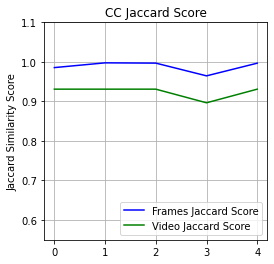

In [69]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.55, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

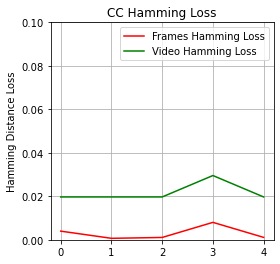

In [70]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

### ML KNN

In [71]:
from skmultilearn.adapt import MLkNN, MLTSVM
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        print(len(ground_truth_video_labels))
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 49, validation: 13
Training+validation data size:  4989
Training data size:  4989
Validation data size:  1636
Validation Hamming Loss:
  0.12434509256025149
Test Hamming Loss:
  0.025900445163901255
Test Jaccard Score:
  0.9220963172804533
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2-th split: train: 49, validation: 13
Training+validation data size:  5041
Training data size:  5041
Validation data size:  1584
Validation Hamming Loss:
  0.0
Test Hamming Loss:
  0.014872521246458924
Test Jaccard Score:
  0.9605169971671388
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
3-th split: train: 50, validation: 12
Training+validation data size:  5435
Training data size:  5435
Validation data size:  1190
Validation Hamming Loss:
  0.06710684273709484
Test Hamming Loss:
  0.01659247268312424
Test Jaccard Score:
  0.9563267233238906
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
4-th s

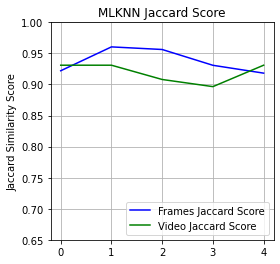

In [72]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

In [ ]:
videos_mean_jac_test


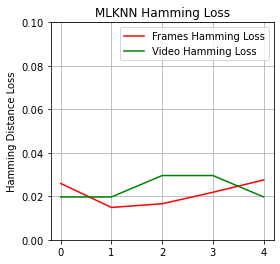

In [73]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
frames_mean_hm_test

In [ ]:
train_df.head()

Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


In [ ]:
multilabel_confusion_matrix(y_test, y_test_pred, labels=range(0,7))


`support`: The number of occurrences of each label in y_true.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']))

In [ ]:
print(type(y_test[0]))
print(type(y_test_pred[0].toarray()))
for i in range(len(y_test)):
    if metrics.hamming_loss(y_test[i].flatten(), Y_pred_chains[4][i].flatten()) > 0:
        print("Ground Truth: ", y_test[i], ", Prediction: ", Y_pred_chains[0][i])
        print("Video data: ", metadata_test.iloc[i])

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

## Break data into chunks of 50 frames or less

In [ ]:
grouped = X_df.groupby(by=['filename', 'face_id'])
## Separating test data
test_ts_list = list()
test_metadata = list()
# X_list is video/face frames, divided into 50 frames chunks
X_list = []
Y_list = []
metadata = []
frame_limit = 50
for key in grouped.groups:
    X_group = grouped.get_group(key)
    # X_group = X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1)
    if len(X_group) >= frame_limit:
        splitted_group = np.array_split(X_group, math.ceil(len(X_group) / frame_limit))
        for g in splitted_group:
            X_list.append(g.drop(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'], axis=1).to_numpy())
            metadata.append({'filename': g.loc[g.index[0], 'filename'], 'face_id':g.loc[g.index[0], 'face_id']})
            Y_list.append(Y_df.loc[g.loc[g.index[0], 'filename']].to_list())
    else:
        X_list.append(X_group.drop(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'], axis=1).to_numpy())
        metadata.append({'filename': X_group.loc[X_group.index[0], 'filename'],  'face_id':X_group.loc[X_group.index[0], 'face_id']})
        Y_list.append(Y_df.loc[g.loc[g.index[0], 'filename']].to_list())

In [ ]:
X_ts = to_time_series_dataset(X_list)

n_series = len(X_ts)
distance_matrix = np.zeros(shape=(n_series, n_series))

# Build distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = X_ts[i]
        y = X_ts[j]
        if i != j:
            dist = soft_dtw(x, y)
            distance_matrix[i, j] = dist

https://scikit-learn.org/stable/modules/multiclass.html#classifierchain


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
X_train, X_test, Y_train, Y_test = train_test_split(X_ts, Y_list, test_size=.2,
                                                    random_state=0)

base_knn =  KNeighborsClassifier(n_neighbors=5)
chains = [ClassifierChain(base_knn, order='random', random_state=i)
          for i in range(7)]
for model in chains:
    model.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])



In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)